# David Kartchner
## House Price Prediction
## 2 Hour Time Limit
## 1/8/18


In [28]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange as trange
import keras
from matplotlib import pyplot as plt
import matplotlib
plt.rcParams['figure.dpi']=300 # Increase image resolution
%matplotlib inline
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
# import seaborn as sns
from sklearn.model_selection import KFold
pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',101)
from sklearn.metrics import mean_squared_error as MSE

### 1.  What are the relevant inputs to predict housing price?

$\alpha$

### First, load the data into Pandas

In [19]:
train = pd.read_csv('train.csv', index_col='Id')
train_x = train.drop('SalePrice', axis=1)
train_indices  = train_x.index
test_x = pd.read_csv('test.csv', index_col='Id')
test_indices = test_x.index
housing_data = pd.concat([train_x, test_x], axis=0)
print len(housing_data)

# Make a column for log price, since this is the value we care about
train["LogPrice"] = np.log(train.SalePrice)
y = train.LogPrice

2919


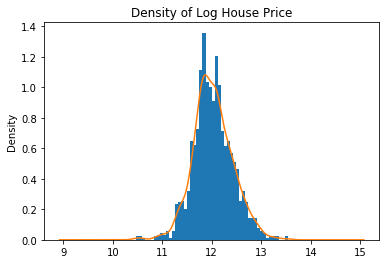

In [20]:
y.hist(bins=50, normed=True)
y.plot(kind='density')
plt.title("Density of Log House Price")
plt.show()

# Recode categorical variables
col_data_types = housing_data.dtypes.to_dict()
numerical_col = [col for col in col_data_types.keys() if col_data_types[col] != object]
object_col = [col for col in col_data_types.keys() if col_data_types[col] == object]


We immediately notice that there are a few houses that are substantially lower cost than the others.  We will explore this further.  All other numeric values appear to be in normal ranges.  Lot size seems to vary widely -- with some people living on a huge estate and others on a tiny plot.  


Let's look at how houses on the top 5 largest lots compare

In [21]:
print housing_data[["LotArea", "GrLivArea"]].nlargest(5, "LotArea")
print housing_data[["LotArea", "GrLivArea"]].nlargest(5, "GrLivArea")

     LotArea  GrLivArea
Id                     
314   215245       2036
336   164660       1786
250   159000       2144
707   115149       1824
452    70761       1533
      LotArea  GrLivArea
Id                      
1299    63887       5642
2550    39290       5095
524     40094       4676
1183    15623       4476
692     21535       4316


The cheap houses seem sort of small, and some (but not all) seem to have abnormal sale (i.e. foreclosure).  We now experiment with a few machine learning algorithms to see how well they perform on this set

In [70]:
pd.get_dummies?

In [80]:
# We note from the data doc that all of the NaN values in the categorical columns come when the house
# possess the feature in question.  We thus eliminate recode each of these with the string "NA"
categorical_data = housing_data[object_col].fillna("NA")

data_with_categoricals = pd.get_dummies(categorical_data, columns=object_col, dummy_na=True, drop_first=True )
full_data = pd.concat([data_with_categoricals, housing_data[numerical_col]], axis=1)


full_data = full_data.fillna(full_data.mean())
full_data = full_data.drop(["1stFlSF", "BsmtFinSF1"])
# We make sure that none of the columns contain NaN values
counts = full_data.count()
print len(counts[counts != full_data.shape[0]])
num_counts = housing_data[numerical_col].count()
# print len(num_counts[num_counts != housing_data[numerical_col].shape[0]])
# print num_counts
# print test_x[numerical_col].count()
print full_data.shape


# Split back into train and test
full_train = full_data.loc[train_indices,:]
full_test = full_data.loc[test_indices,:]

null_col = test_x.columns[test_x.isnull().any()]
full_data.head()


ValueError: labels ['1stFlSF' 'BsmtFinSF1'] not contained in axis

<Container object of 30 artists>

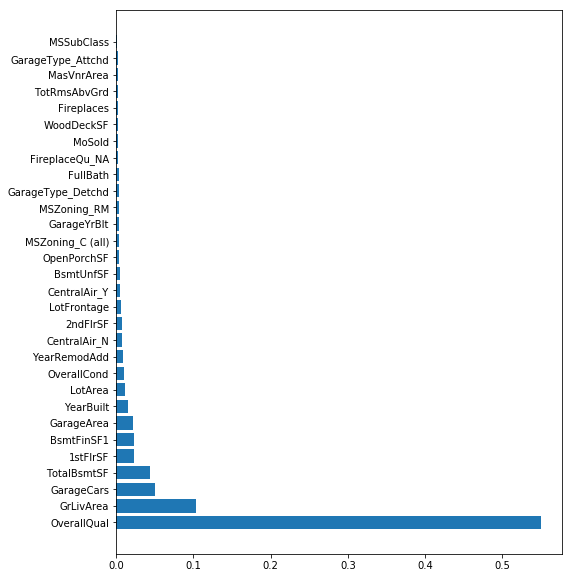

In [59]:
# For the sake of time, we prune out useless columns by using Random Forest feature selection
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1).fit(full_train, y)
data_columns = full_train.columns
sorted_importances = np.argsort(rf.feature_importances_)[::-1]
rf.feature_importances_[sorted_importances]
plt.figure(figsize = (8,10))
plt.barh(range(30), rf.feature_importances_[sorted_importances][:30],tick_label = data_columns[sorted_importances][:30])
# plt.hist(rf.feature_importances_, bins=50)



# # Describe lot/physical location of house
# lot_variables = ["LotFrontage", "LotArea",'Street','Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood']

# # Describe size of house
# size = []

# # Describe amenities of house
# amenities = ['Utilities', 'Fireplaces','Fence','PoolArea','PoolQC']

In [60]:
# Now we compare the most important features from Random Forests to the most important features 
# selected by sklearn.featue_selection.selectkbest
print MSE(rf.predict(full_train), y)
# rf_pred = pd.DataFrame({"Id":test_indices,"SalePrice":np.exp(rf.predict(full_test))})
rf_pred = pd.DataFrame({"Id":test_indices,"SalePrice":np.exp(rf.predict(full_test))})
rf_pred.to_csv("log_y_rf_100_tree_pred.csv", index=False, header=True)

0.002779008115910539


### Look at a baseline linear regression model

In [81]:
for t_ind, v_ind in KFold(5).split(full_train):
#     print type(t_ind)
#     ols_mse = []
#     ols = LinearRegression().fit(full_train.loc[t_ind], y.loc[t_ind])
#     ols_preds = ols.predict(full_train.loc[v_ind])
#     ols_score = MSE(ols_preds, y.loc[v_ind])
#     ols_mse.append(ols_score)
    
    ridge_mse = []
    ridge = Ridge().fit(full_train.loc[t_ind, numerical_col], y.loc[t_ind])
    ridge_preds = ridge.predict(full_train.loc[v_ind, numerical_col])
    ridge_score = MSE(ridge_preds, y.loc[v_ind])
    ridge_mse.append(ridge_score)
    
    lasso_mse = []
    lasso = Lasso().fit(full_train.loc[t_ind], y.loc[t_ind])
    lasso_preds = lasso.predict(full_train.loc[v_ind])
    lasso_score = MSE(lasso_preds, y.loc[v_ind])
    lasso_mse.append(lasso_score)
    
print "OLS: {0}\nRidge: {1}\nLassso: {2}".format(np.mean(ols_mse), np.mean(ridge_mse), np.mean(lasso_mse))

/Users/davidspencerkartchner/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [68]:
?LinearRegression().fit()

/Users/davidspencerkartchner/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


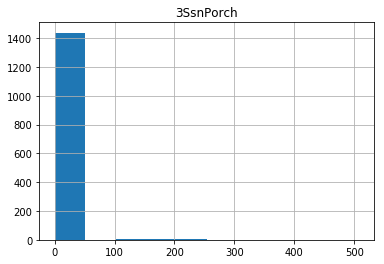

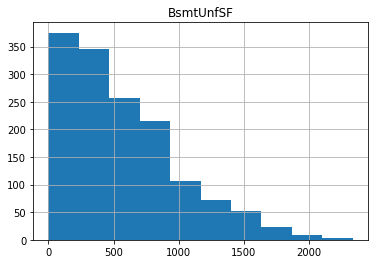

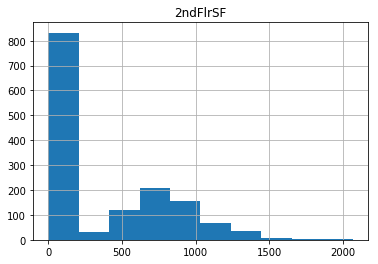

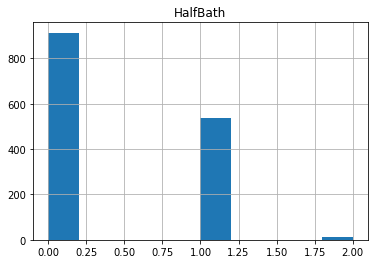

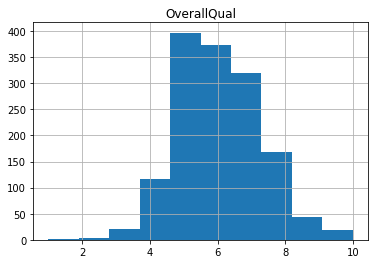

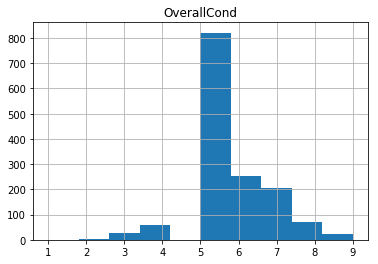

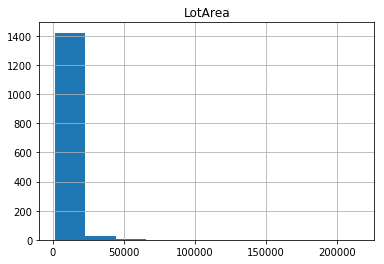

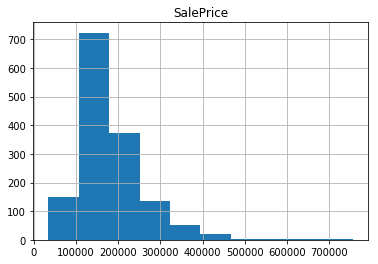

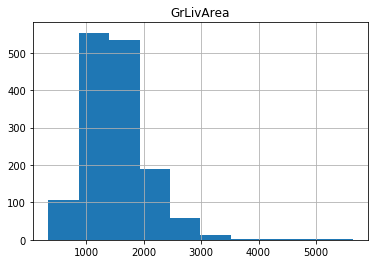

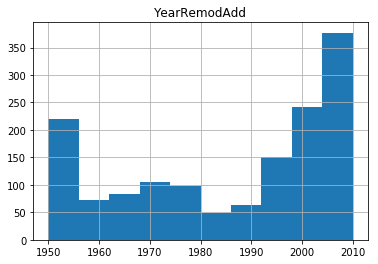

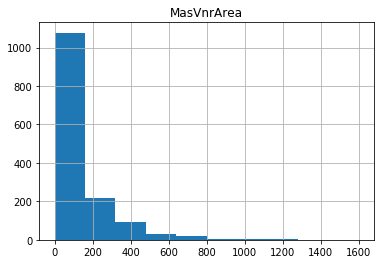

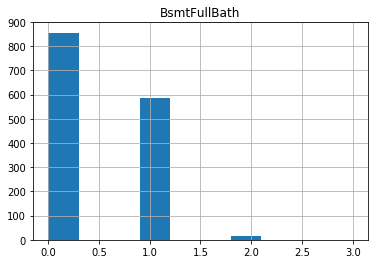

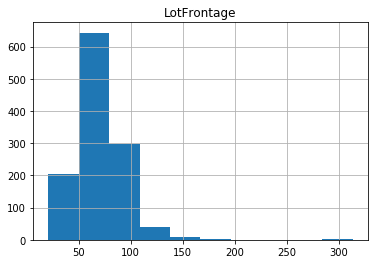

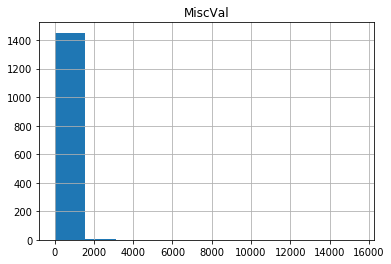

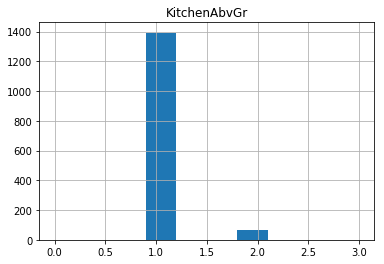

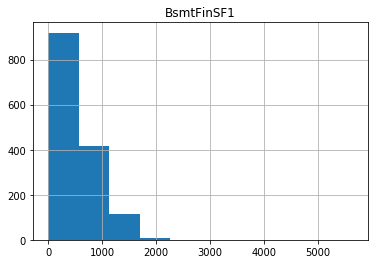

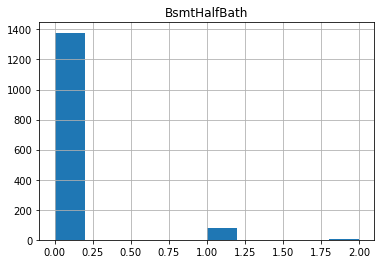

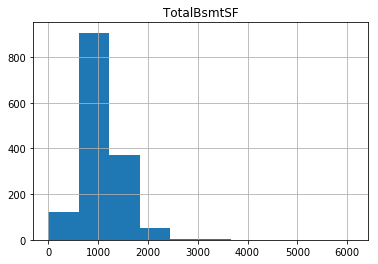

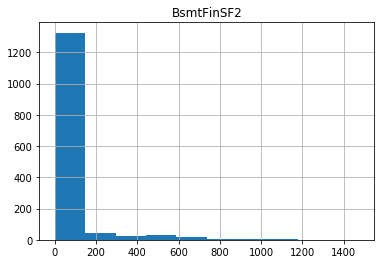

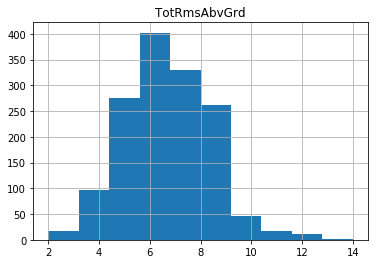

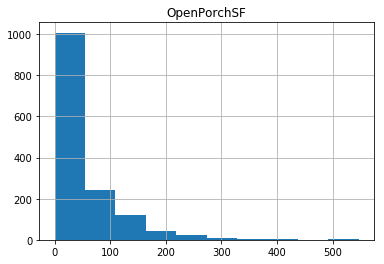

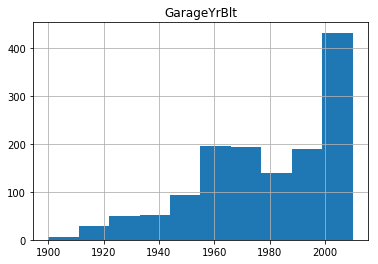

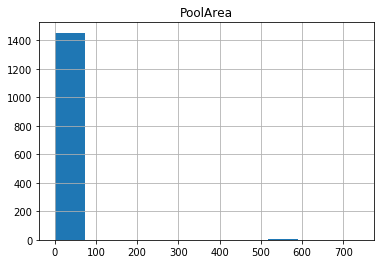

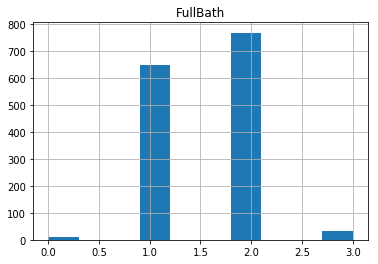

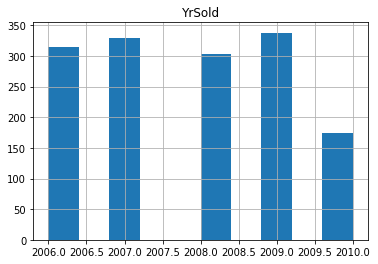

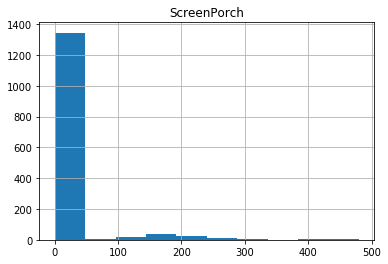

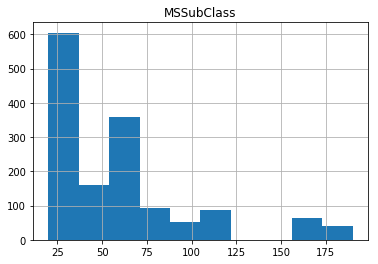

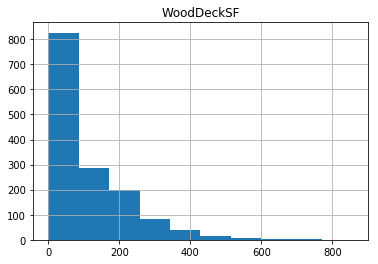

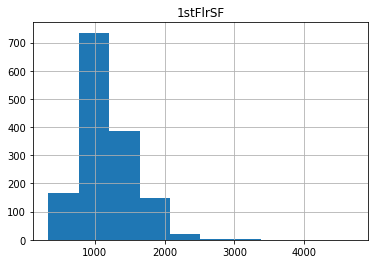

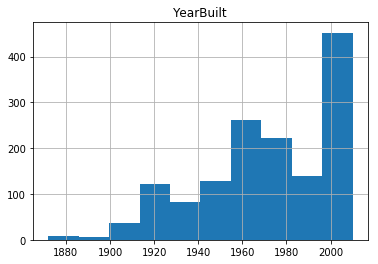

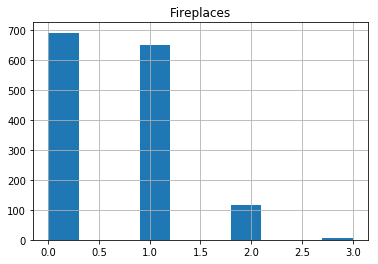

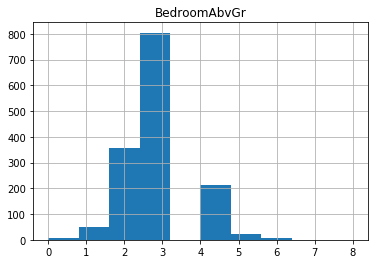

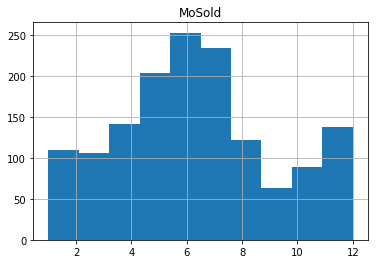

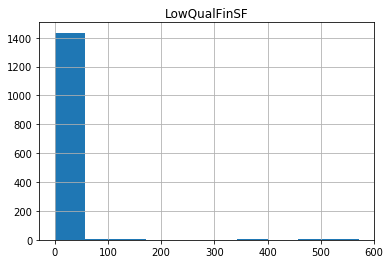

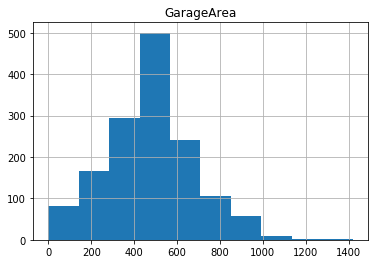

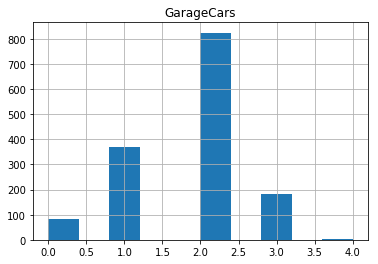

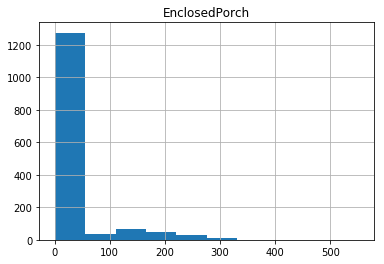

In [20]:
for col in numerical_col:
    housing_data.hist(col)
    plt.show()

(array([nan, nan, nan, nan, nan, nan, nan, nan, 'BrkCmn', 'BrkFace',
       'None', 'Stone'], dtype=object), array([  1,   1,   1,   1,   1,   1,   1,   1,  15, 445, 864, 128]))


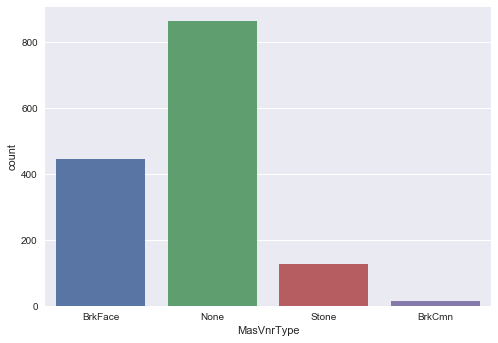

(array(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], dtype=object), array([ 263,   94,   47,    4, 1052]))


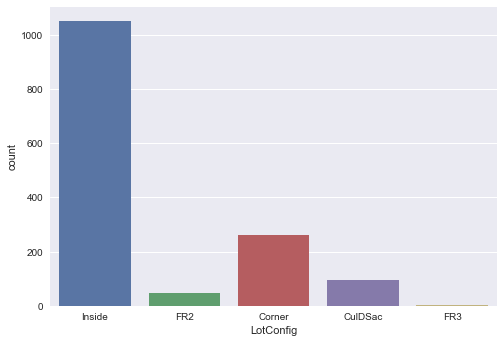

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, 'Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype=object), array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1, 

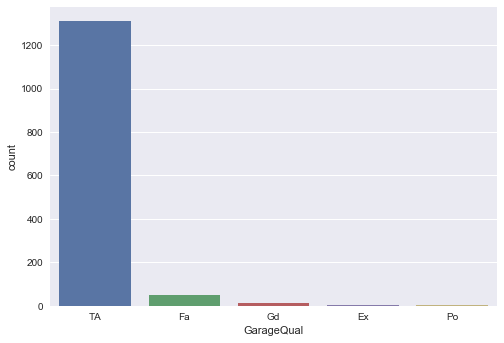

(array(['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd',
       'HdBoard', 'ImStucc', 'MetalSd', 'Plywood', 'Stone', 'Stucco',
       'VinylSd', 'Wd Sdng', 'WdShing'], dtype=object), array([ 20,   1,   2,  50,   1,  61, 222,   1, 220, 108,   2,  25, 515,
       206,  26]))


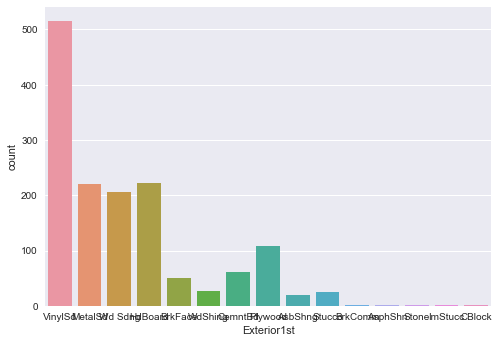

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, 'Fin', 'RFn', 'Unf'], dtype=object), array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1, 352, 422, 605]))


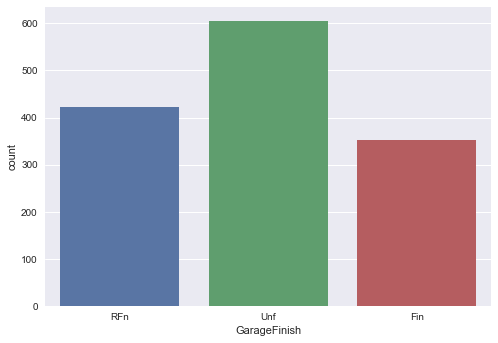

(array([nan, nan, nan, ..., 'GdWo', 'MnPrv', 'MnWw'], dtype=object), array([  1,   1,   1, ...,  54, 157,  11]))


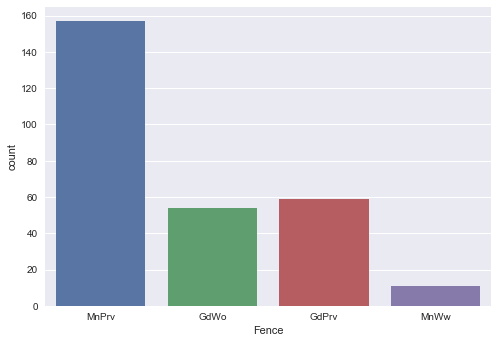

(array([nan, 'FuseA', 'FuseF', 'FuseP', 'Mix', 'SBrkr'], dtype=object), array([   1,   94,   27,    3,    1, 1334]))


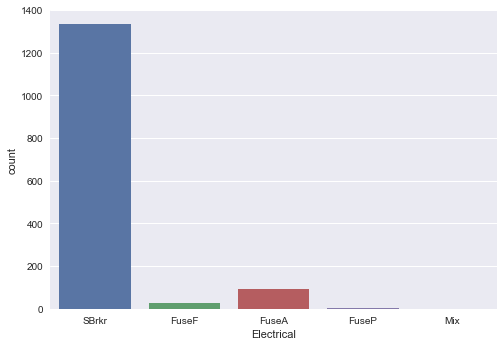

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Ex', 'Fa',
       'Gd', 'TA'], dtype=object), array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1, 121,  35,
       618, 649]))


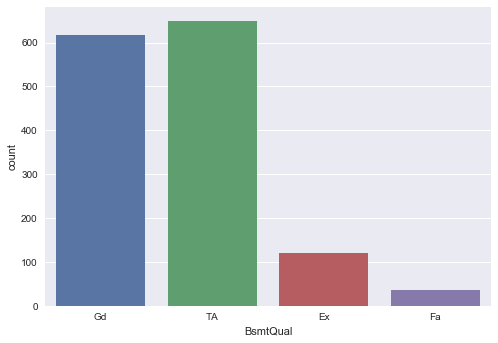

(array(['Abnorml', 'AdjLand', 'Alloca', 'Family', 'Normal', 'Partial'],
      dtype=object), array([ 101,    4,   12,   20, 1198,  125]))


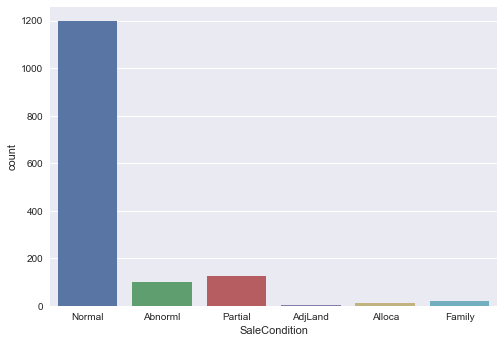

(array(['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story',
       'SFoyer', 'SLvl'], dtype=object), array([154,  14, 726,   8,  11, 445,  37,  65]))


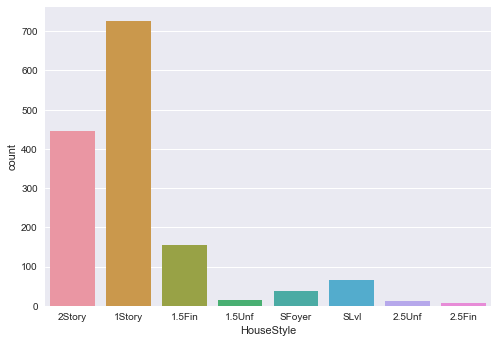

(array(['COD', 'CWD', 'Con', 'ConLD', 'ConLI', 'ConLw', 'New', 'Oth', 'WD'],
      dtype=object), array([  43,    4,    2,    9,    5,    5,  122,    3, 1267]))


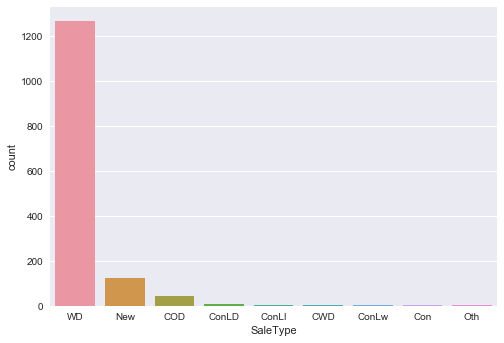

(array(['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood'], dtype=object), array([146, 634, 647,  24,   6,   3]))


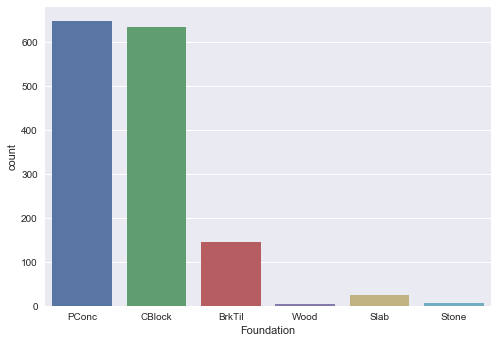

(array(['Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype=object), array([   3,   28,  146,    1, 1282]))


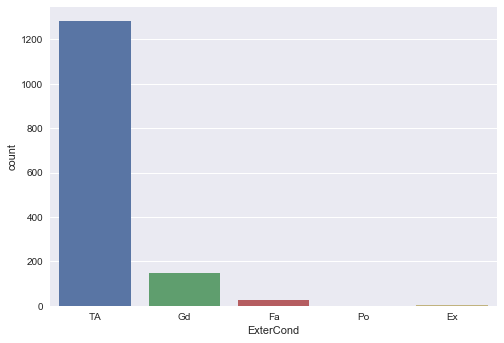

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Fa', 'Gd',
       'Po', 'TA'], dtype=object), array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,   45,   65,    2, 1311]))


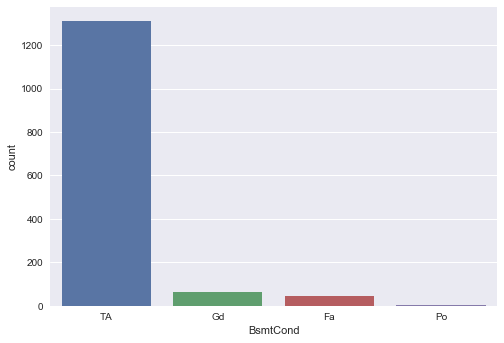

(array(['Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype=object), array([741,  49, 241,   1, 428]))


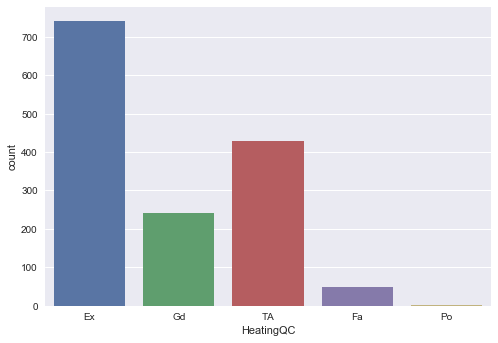

(array(['N', 'Y'], dtype=object), array([  95, 1365]))


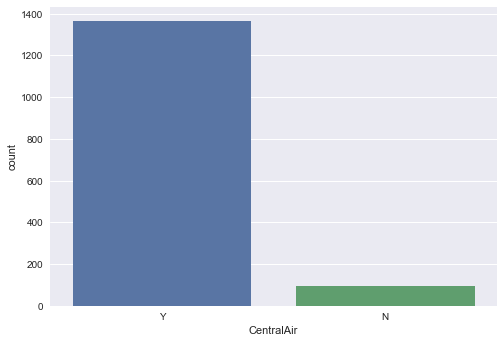

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Av',
       'Gd', 'Mn', 'No'], dtype=object), array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1, 221,
       134, 114, 953]))


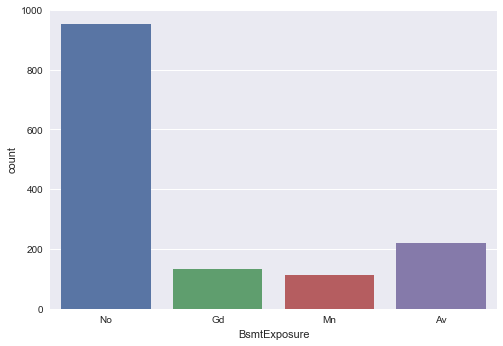

(array(['AllPub', 'NoSeWa'], dtype=object), array([1459,    1]))


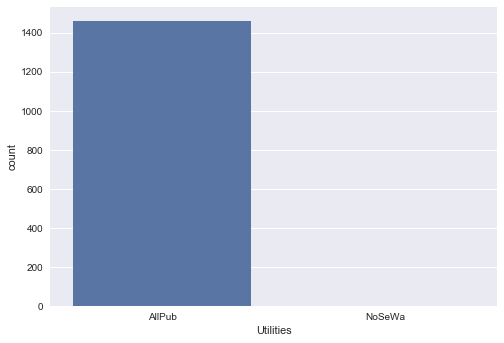

(array(['IR1', 'IR2', 'IR3', 'Reg'], dtype=object), array([484,  41,  10, 925]))


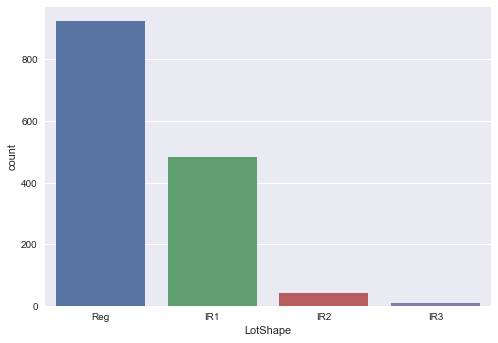

(array([nan, nan, nan, ..., 'Othr', 'Shed', 'TenC'], dtype=object), array([ 1,  1,  1, ...,  2, 49,  1]))


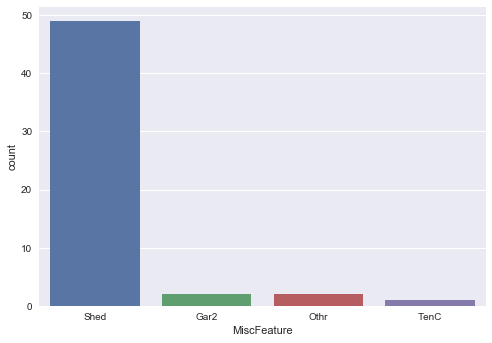

(array(['N', 'P', 'Y'], dtype=object), array([  90,   30, 1340]))


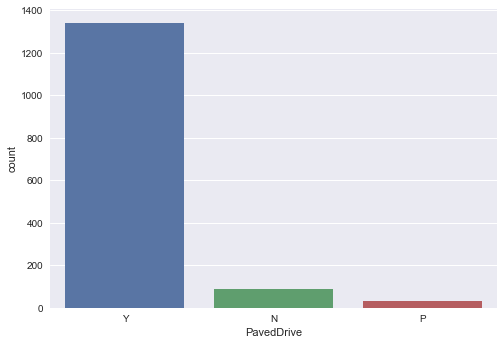

(array(['Gtl', 'Mod', 'Sev'], dtype=object), array([1382,   65,   13]))


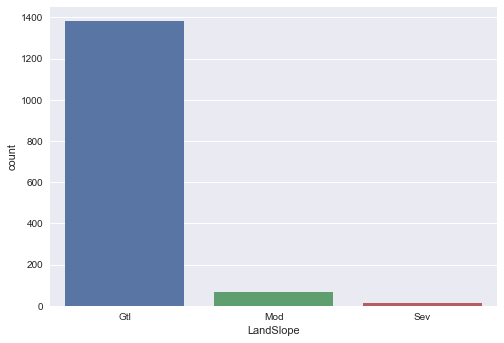

(array(['AsbShng', 'AsphShn', 'Brk Cmn', 'BrkFace', 'CBlock', 'CmentBd',
       'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'Stone',
       'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'], dtype=object), array([ 20,   3,   7,  25,   1,  60, 207,  10, 214,   1, 142,   5,  26,
       504, 197,  38]))


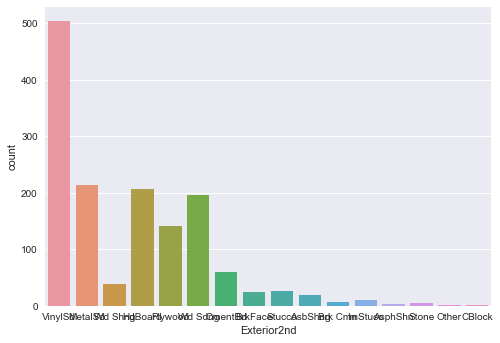

(array(['Floor', 'GasA', 'GasW', 'Grav', 'OthW', 'Wall'], dtype=object), array([   1, 1428,   18,    7,    2,    4]))


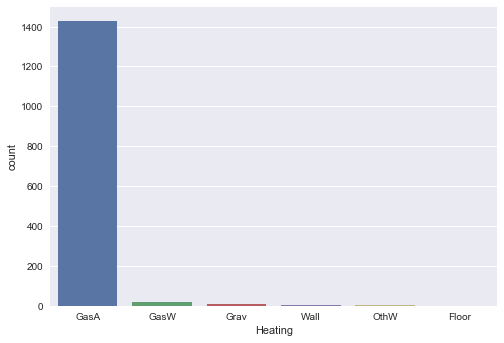

(array([nan, nan, nan, ..., 'Ex', 'Fa', 'Gd'], dtype=object), array([1, 1, 1, ..., 2, 2, 3]))


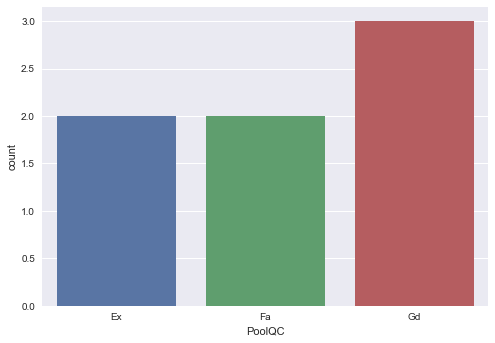

(array(['Ex', 'Fa', 'Gd', 'TA'], dtype=object), array([100,  39, 586, 735]))


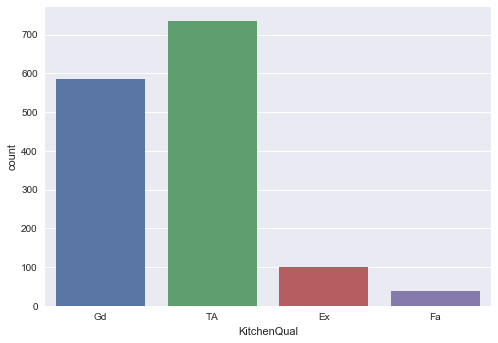

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'ALQ',
       'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf'], dtype=object), array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,   19,   33,   14,   46,   54, 1256]))


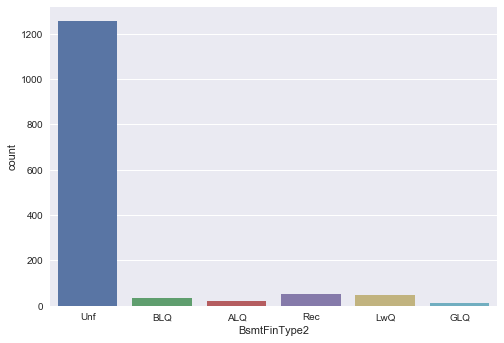

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'ALQ',
       'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf'], dtype=object), array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1, 220, 148,
       418,  74, 133, 430]))


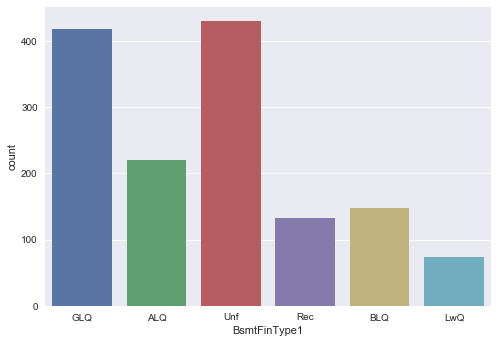

(array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn'],
      dtype=object), array([   2,    6, 1445,    1,    2,    1,    1,    2]))


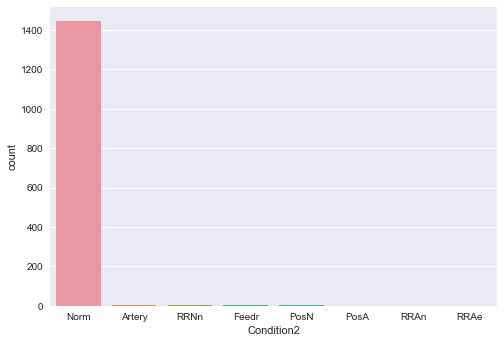

(array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe',
       'RRNn'], dtype=object), array([  48,   81, 1260,    8,   19,   11,   26,    2,    5]))


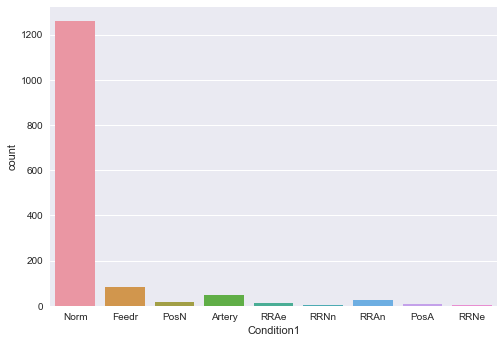

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, '2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort',
       'Detchd'], dtype=object), array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   6, 

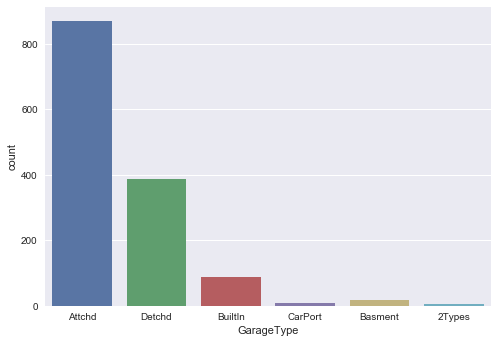

(array(['Bnk', 'HLS', 'Low', 'Lvl'], dtype=object), array([  63,   50,   36, 1311]))


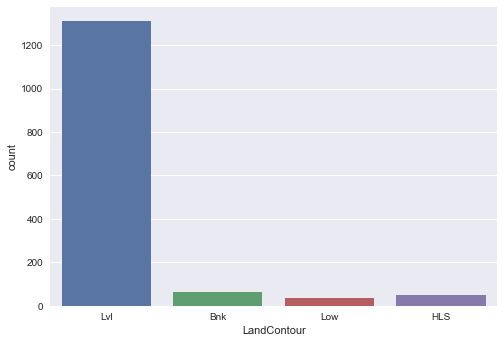

(array(['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar&Grv',
       'WdShake', 'WdShngl'], dtype=object), array([   1, 1434,    1,    1,    1,   11,    5,    6]))


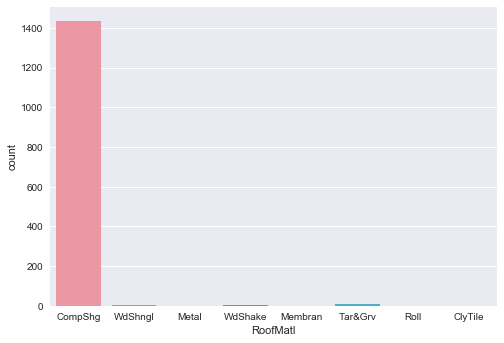

(array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
       'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
       'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
       'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
       'Veenker'], dtype=object), array([ 17,   2,  16,  58,  28, 150,  51, 100,  79,  37,  17,  49, 225,
         9,  73,  41,  77, 113,  25,  74,  59,  86,  25,  38,  11]))


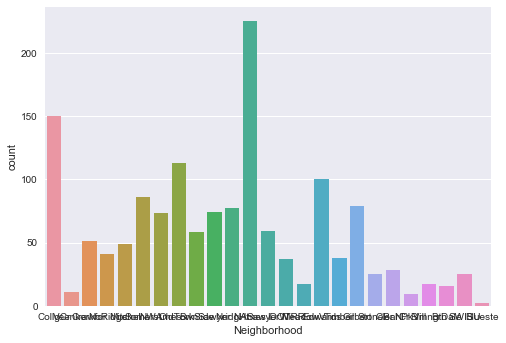

(array(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'], dtype=object), array([1220,   31,   52,   43,  114]))


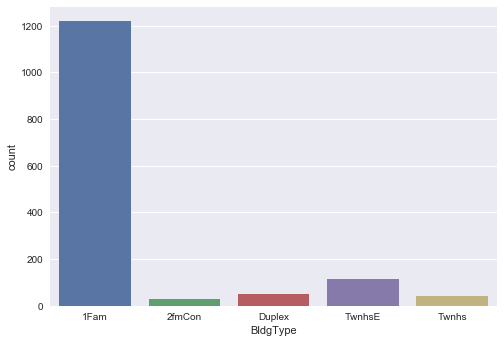

(array(['Ex', 'Fa', 'Gd', 'TA'], dtype=object), array([ 52,  14, 488, 906]))


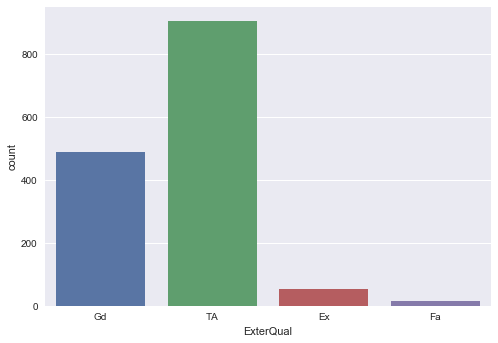

(array(['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sev', 'Typ'], dtype=object), array([  14,    5,   31,   34,   15,    1, 1360]))


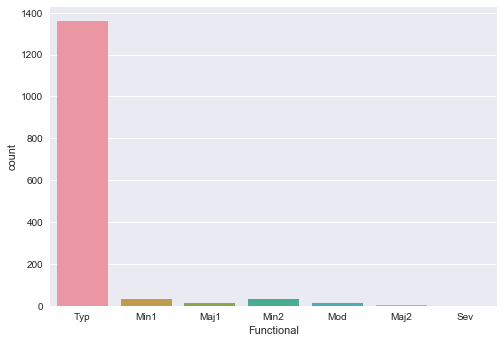

(array([nan, nan, nan, ..., nan, 'Grvl', 'Pave'], dtype=object), array([ 1,  1,  1, ...,  1, 50, 41]))


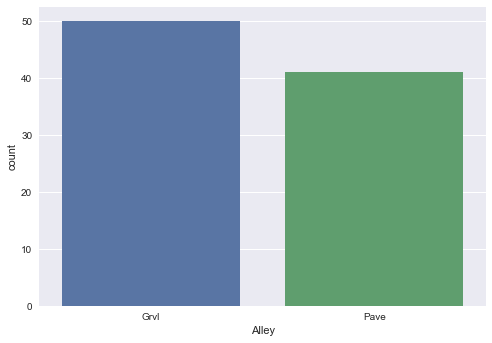

(array(['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed'], dtype=object), array([  13, 1141,   11,  286,    7,    2]))


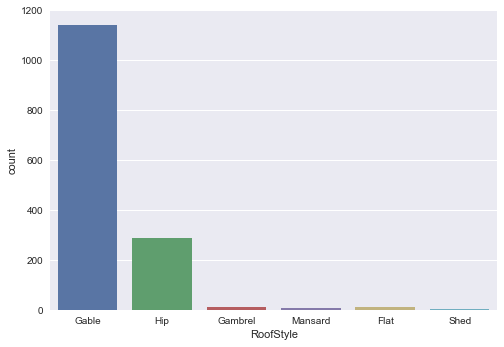

(array(['Grvl', 'Pave'], dtype=object), array([   6, 1454]))


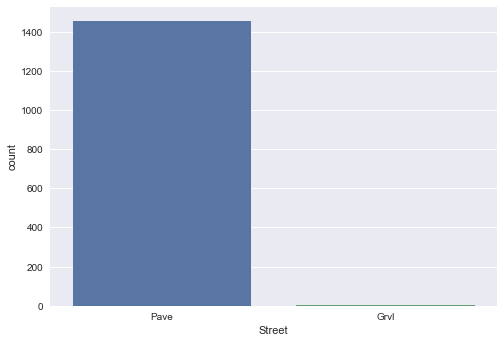

(array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object), array([  10,   65,   16, 1151,  218]))


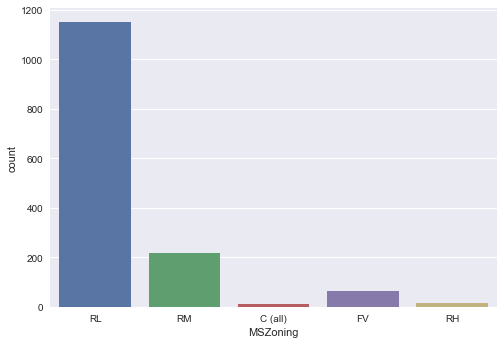

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

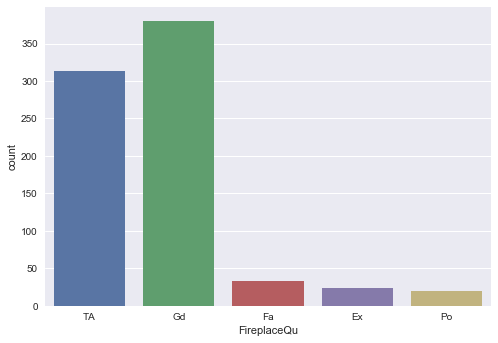

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, 'Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype=object), array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1, 

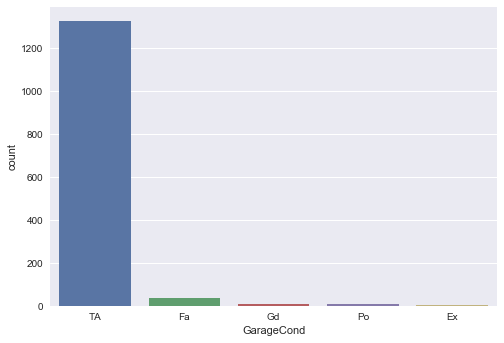

In [42]:
for col in object_col:
    print np.unique(housing_data[col], return_counts=True)
    sns.countplot(x=col, data=housing_data)
    plt.show()

In [64]:
housing_data[numerical_col].fillna(-1)
housing_data[numerical_col]
housing_data[numerical_col].count()
# for x in ['MasVnrArea','GarageYrBlt','LotFrontage']:
#     numerical_col.remove(x)
# housing_data.LotFrontage
SelectKBest(score_func=f_regression).fit_transform(housing_data[numerical_col], housing_data.SalePrice)

/Users/davidspencerkartchner/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


array([[   7, 1710, 2003, ..., 2003,  548,    2],
       [   6, 1262, 1976, ..., 1976,  460,    2],
       [   7, 1786, 2002, ..., 2001,  608,    2],
       ...,
       [   7, 2340, 2006, ..., 1941,  252,    1],
       [   5, 1078, 1996, ..., 1950,  240,    1],
       [   5, 1256, 1965, ..., 1965,  276,    1]])

In [65]:
x = sm.add_constant(housing_data[numerical_col])

In [72]:
model = sm.OLS(housing_data.SalePrice, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     195.0
Date:                Mon, 08 Jan 2018   Prob (F-statistic):               0.00
Time:                        14:24:57   Log-Likelihood:                -17336.
No. Observations:                1460   AIC:                         3.474e+04
Df Residuals:                    1428   BIC:                         3.490e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.026e+05   1.43e+06      0.352      0.725    -2.3e+06     3.3e+06
3SsnPorch        18.7714     31.680      0.593      0.554     -43.372      80.915
BsmtUnfSF         0.7877      2.431      0.324      0.746      -3.980       5.556
2ndFlrSF         18.9464      5.699      3.324      0.001       7.766      30.126
HalfBath      -1326.8616   2687.997     -0.494      0.622   -6599.707    3945.984
OverallQual    1.791e+04   1194.881     14.985      0.000    1.56e+04    2.02e+04
OverallCond    4418.7948   1032.703      4.279      0.000    2393.017    6444.573
LotArea           0.3962      0.102      3.898      0.000       0.197       0.596
GrLivArea        31.7838      5.700      5.576      0.000      20.602      42.965
YearRemodAdd    137.0739     66.329      2.067      0.039       6.961     267.187
BsmtFullBath   8534.8941   2632.605      3.242      0.001    3370.707    1.37e+04
MiscVal          -0.8912      1.873     -0.476      0.634      -4.566       2.783
KitchenAbvGr  -1.293e+04   5249.715     -2.463      0.014   -2.32e+04   -2629.790
BsmtFinSF1       11.8336      2.527      4.683      0.000       6.876      16.791
BsmtHalfBath   2467.2005   4127.234      0.598      0.550   -5628.891    1.06e+04
TotalBsmtSF       9.8931      3.395      2.914      0.004       3.234      16.552
BsmtFinSF2       -2.7283      4.541     -0.601      0.548     -11.637       6.180
TotRmsAbvGrd   5132.3181   1248.626      4.110      0.000    2682.980    7581.656
OpenPorchSF      -5.6194     15.284     -0.368      0.713     -35.601      24.362
PoolArea        -42.6137     23.770     -1.793      0.073     -89.242       4.015
FullBath       3577.4891   2841.360      1.259      0.208   -1996.199    9151.177
YrSold         -757.6439    709.344     -1.068      0.286   -2149.111     633.824
ScreenPorch      57.8860     17.351      3.336      0.001      23.849      91.923
MSSubClass     -162.6729     26.466     -6.147      0.000    -214.589    -110.757
WoodDeckSF       26.3727      8.043      3.279      0.001      10.596      42.149
1stFlrSF         18.8377      6.156      3.060      0.002       6.762      30.914
YearBuilt       346.6535     61.163      5.668      0.000     226.675     466.632
Fireplaces     3596.8951   1782.470      2.018      0.044     100.354    7093.436
BedroomAbvGr  -1.053e+04   1710.860     -6.155      0.000   -1.39e+04   -7174.711
MoSold         -115.3486    348.085     -0.331      0.740    -798.161     567.464
LowQualFinSF     -6.0003     14.870     -0.404      0.687     -35.169      23.168
GarageArea        1.3962      9.787      0.143      0.887     -17.802      20.594
GarageCars     1.063e+04   2882.340      3.689      0.000    4979.674    1.63e+04
EnclosedPorch     8.7220     17.022      0.512      0.608     -24.668      42.112
=================================================

In [82]:
relevant_vars = ['GarageCars','Fireplaces','YearBuilt','WoodDeckSF','MSSubClass',
                 'ScreenPorch','OverallQual','LotArea','GrLivArea',
                 'TotalBsmtSF']
x = sm.add_constant(housing_data[relevant_vars])
model = sm.OLS(housing_data.SalePrice, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     534.5
Date:                Mon, 08 Jan 2018   Prob (F-statistic):               0.00
Time:                        15:09:13   Log-Likelihood:                -17416.
No. Observations:                1460   AIC:                         3.485e+04
Df Residuals:                    1449   BIC:                         3.491e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.449e+05    8.3e+04     -8.971      0.000   -9.08e+05   -5.82e+05
GarageCars   1.239e+04   1762.001      7.029      0.000    8928.912    1.58e+04
Fireplaces   6004.6402   1777.055      3.379      0.001    2518.766    9490.515
YearBuilt     345.0882     43.687      7.899      0.000     259.391     430.785
WoodDeckSF     39.1867      8.221      4.767      0.000      23.060      55.314
MSSubClass   -153.0738     24.477     -6.254      0.000    -201.088    -105.059
ScreenPorch    55.3317     17.798      3.109      0.002      20.420      90.244
OverallQual  2.087e+04   1131.452     18.448      0.000    1.87e+04    2.31e+04
LotArea         0.4674      0.105      4.443      0.000       0.261       0.674
GrLivArea      47.4741      2.622     18.103      0.000      42.330      52.618
TotalBsmtSF    18.9056      2.919      6.477      0.000      13.180      24.632
==============================================================================
Omnibus:                      425.876   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49178.807
Skew:                          -0.012   Prob(JB):                         0.00
Kurtosis:                      31.433   Cond. No.                     1.26e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

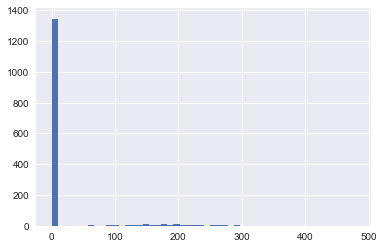

In [83]:
housing_data.ScreenPorch.hist(bins=50)

34900

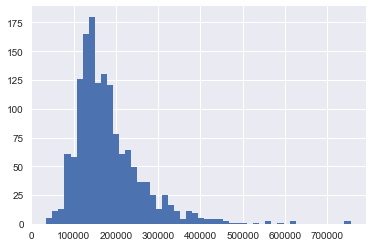

In [86]:
housing_data.SalePrice.hist(bins=50)
housing_data.SalePrice.min()